In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn import metrics
import os
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving temperature_data.csv to temperature_data.csv


In [2]:
import pandas as pd

df = pd.read_csv('temperature_data.csv',index_col=0)

df.head()

,Tokyo(Kanto),Neriima(Kanto),fuchu(Kanto),Naha(kyushu),fukuoka(kyushu),Dazaihu(kyushu)
timestep,,,,,,
1,5.3,4.5,4.2,18.3,6.8,5.2
2,6.2,5.6,4.3,17.8,6.0,4.8
3,4.9,4.1,3.7,17.4,5.4,3.3
4,5.1,3.8,4.0,19.9,6.9,4.8
5,7.4,6.5,6.0,22.1,8.2,7.0


In [6]:
INPUT_feature_col = [
    "Tokyo(Kanto)","Neriima(Kanto)","fuchu(Kanto)","Naha(kyushu)","fukuoka(kyushu)","Dazaihu(kyushu)"
    ]

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.python.keras.utils.vis_utils import plot_model

In [8]:
dataset = df[INPUT_feature_col].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
df_ax = pd.DataFrame(dataset)

# 今回は東京の平均気温データの中間層を取得

In [9]:
rawdata = df_ax.loc[:, [0]]
raw_data = rawdata.values
raw_data = raw_data.reshape([358])
raw_data.shape
len_raw = len(rawdata)
axis_x = np.linspace(0,len_raw,len_raw)

In [10]:
N_RNN = 10  # 1セットのデータ数
N_SAMPLE = len(raw_data)-N_RNN  # サンプル数
N_IN_OUT = 1 # 入力層・出力層のニューロン数
N_MID = 20  # 中間層のニューロン数
shape_ = (N_SAMPLE, N_RNN, )

x_encoder = np.zeros(shape_)  # encoderの入力
x_decoder = np.zeros(shape_)  # decoderの入力
y_decoder = np.zeros(shape_)  # decoderの正解

for i in range(N_SAMPLE):
    x_encoder[i] = raw_data[i:i+N_RNN] #正弦(sin)関数を10づつ入力
    x_decoder[i, 1:] = raw_data[i:i+N_RNN-1]  # 最初の値は0のままでひとつ後にずらす
    y_decoder[i] = raw_data[i:i+N_RNN]  # 正解は余弦(cos)関数の値をそのまま入れる
print(x_encoder.shape)
print(y_decoder.shape)
print(x_decoder.shape)


# サンプル数、時系列の数、入力層のニューロン数にreshape
x_encoder = x_encoder.reshape(shape_+(N_IN_OUT,))
x_decoder = x_decoder.reshape(shape_+(N_IN_OUT,))
y_decoder = y_decoder.reshape(shape_+(N_IN_OUT,))
#print(x_encoder.shape)

(348, 10)
(348, 10)
(348, 10)


In [11]:
def train_model():
    # input
    encoder_input = Input(shape=(N_RNN, N_IN_OUT)) # encoderの入力層
    decoder_input = Input(shape=(N_RNN, N_IN_OUT)) # decoderの入力層

    # encoder
    # return_stateをTrueにすることで、状態（htとメモリセル）が得られる。return_sequnceは不要
    encoder_output, state_h, state_c = LSTM(N_MID, return_state=True)(encoder_input)  # encoder LSTMの最終出力、状態(ht)、状態(メモリセル)
    encoder_states = [state_h, state_c] # LSTM結果のencoder_stateをdecoderのLSTM中間状態に渡す

    # decoder
    decoder_lstm = LSTM(N_MID, return_sequences=True, return_state=True)  # return_stateをTrueにすることで、状態（htとメモリセル）が得られる。
    decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)  # encoderから得る状態を使用。状態(htとメモリセル)は不要
    decoder_dense = Dense(N_IN_OUT, activation='linear') # 予測で再利用のために全結合を定義
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output)  # 入力と出力を設定し、Modelクラスでモデルを作成
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    #SVG(model_to_dot(model).create(prog='dot', format='svg'))
    # モデルの画像をpng形式で保存したいとき
    # from keras.utils import plot_model
    # plot_model(model, to_file='model.png')

    return model, encoder_input, encoder_states, decoder_lstm, decoder_dense

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  1760        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 10, 20), (No 1760        input_2[0]

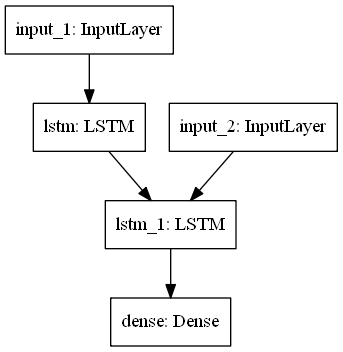

In [12]:
# 訓練モデル定義と出力
model, encoder_input, encoder_states, decoder_lstm, decoder_dense = train_model()
#from tf.keras.utils import plot_model
tf.keras.utils.plot_model(model)

In [13]:
epochs=100

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
348/348 [==============================] - 2s 5ms/sample - loss: 0.4634 - acc: 0.0029
Epoch 2/100
348/348 [==============================] - 0s 646us/sample - loss: 0.3056 - acc: 0.0029
Epoch 3/100
348/348 [==============================] - 0s 612us/sample - loss: 0.1803 - acc: 0.0029
Epoch 4/100
348/348 [==============================] - 0s 554us/sample - loss: 0.0626 - acc: 0.0049
Epoch 5/100
348/348 [==============================] - 0s 729us/sample - loss: 0.0234 - acc: 0.0057
Epoch 6/100
348/348 [==============================] - 0s 635us/sample - loss: 0.0187 - acc: 0.0057
Epoch 7/100
348/348 [==============================] - 0s 655us/sample - loss: 0.0159 - acc: 0.0057
Epoch 8/100
348/348 [==============================] - 0s 643us/sample - loss: 0.0128 - acc: 0.0057
Epoch 9/100
348/348 [==============================] - 0s 616us/sample - loss: 0.0107 - acc: 0.0057
Epoch 10

348/348 [==============================] - 0s 783us/sample - loss: 0.0050 - acc: 0.0057
Epoch 79/100
348/348 [==============================] - 0s 617us/sample - loss: 0.0050 - acc: 0.0057
Epoch 80/100
348/348 [==============================] - 0s 658us/sample - loss: 0.0050 - acc: 0.0057
Epoch 81/100
348/348 [==============================] - 0s 681us/sample - loss: 0.0050 - acc: 0.0057
Epoch 82/100
348/348 [==============================] - 0s 589us/sample - loss: 0.0050 - acc: 0.0057
Epoch 83/100
348/348 [==============================] - 0s 588us/sample - loss: 0.0050 - acc: 0.0057
Epoch 84/100
348/348 [==============================] - 0s 580us/sample - loss: 0.0049 - acc: 0.0057
Epoch 85/100
348/348 [==============================] - 0s 847us/sample - loss: 0.0049 - acc: 0.0057
Epoch 86/100
348/348 [==============================] - 0s 706us/sample - loss: 0.0049 - acc: 0.0057
Epoch 87/100
348/348 [==============================] - 0s 663us/sample - loss: 0.0049 - acc: 0.0057
Epo

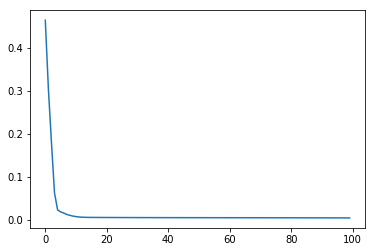

In [14]:
history = model.fit([x_encoder, x_decoder], y_decoder,epochs=epochs)
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

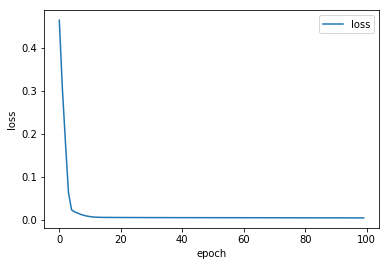

In [15]:
plt.plot(range(epochs), history.history['loss'], label='loss')
#plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

In [16]:
def predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense):
    # encoderのモデルを構築
    encoder_model = Model(encoder_input, encoder_states)

    # decoderのモデルを構築
    decoder_input = Input(shape=(1, N_IN_OUT)) # (1, 1)

    # n_midは中間層のニューロン数(今回は20)
    # 状態(ht)と状態(メモリセル)の入力定義
    decoder_state_in = [Input(shape=(N_MID,)), Input(shape=(N_MID,))]

    decoder_output, decoder_state_h, decoder_state_c = \
        decoder_lstm(decoder_input, initial_state=decoder_state_in) # 既存の学習済みLSTM層を使用
    decoder_states = [decoder_state_h, decoder_state_c]

    decoder_output = decoder_dense(decoder_output) # 既存の学習済み全結合層を使用
    decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_states) # リストを+で結合

    return encoder_model, decoder_model

# 予測モデル定義
encoder_model, decoder_model = predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense)

In [17]:
def predict(x_test):
    state_value = encoder_model.predict(x_test)  # encoderにデータを投げて状態(htとメモリセル)取得
    #print(state_value)
    y_decoder = np.zeros((1, 1, 1)) # 出力の値
    predicted = [] # 変換結果

    for i in range(N_RNN):
        y, h, c = decoder_model.predict([y_decoder] + state_value)  # 前の出力と状態を渡す
        y = y[0][0][0]
        predicted.append(y)
        y_decoder[0][0][0] = y  # 次に渡す値
        state_value = [h, c] # 次に渡す状態

    return predicted

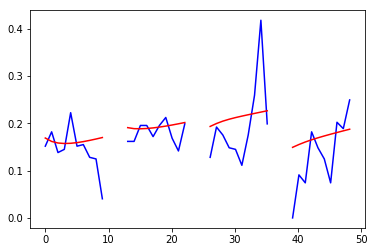

In [18]:
len_raw
demo_idices = [0, 13, 26, 39]  # デモデータのインデックス
for i in demo_idices:
    x_test = x_encoder[i:i+1] # 入力を一部取り出す(x_encoderは40.10,1の3次元配列で、1次元目がdemo_indicesの配列を10個取り出している)
    y_test = predict(x_test)

    plt.plot(axis_x[i:i+N_RNN], x_test.reshape(-1), color="b") # 変換前（青）
    plt.plot(axis_x[i:i+N_RNN], y_test, color="r") # 変換後（赤）
    #print(y_test.shape)
    #print(x_test.reshape(-1))
plt.show()    

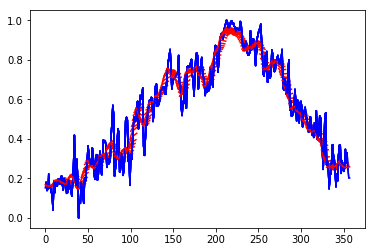

In [19]:
len_raws = len_raw - N_RNN
for i in range(len_raws):
    x_test = x_encoder[i:i+1] # 入力を一部取り出す(x_encoderは40.10,1の3次元配列で、1次元目がdemo_indicesの配列を10個取り出している)
    y_test = predict(x_test)

    plt.plot(axis_x[i:i+N_RNN], x_test.reshape(-1), color="b") # 変換前（青）
    plt.plot(axis_x[i:i+N_RNN], y_test, color="r") # 変換後（赤）
    #print(y_test.shape)
    #print(x_test.reshape(-1))
plt.show()    

In [20]:
demo_index = []
demo_index.append(0)
x = 0
for i in range(len_raw) :
    if x < len_raw - N_RNN -N_RNN :
        x = x + N_RNN
        demo_index.append(x)

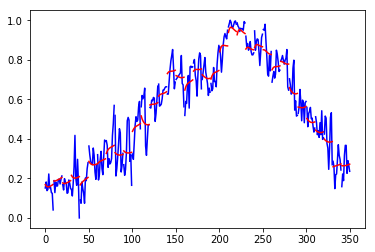

In [22]:
for i in demo_index:
    x_test = x_encoder[i:i+1] # 入力を一部取り出す(x_encoderは40.10,1の3次元配列で、1次元目がdemo_indicesの配列を10個取り出している)
    #print(i)
    y_test = predict(x_test)

    plt.plot(axis_x[i:i+N_RNN], x_test.reshape(-1), color="b") # 変換前（青）
    plt.plot(axis_x[i:i+N_RNN], y_test, color="r") # 変換後（赤）
    #print(y_test.shape)
    #print(x_test.reshape(-1))
plt.show()   